# Predicting Divorce
## Author: Ahria Dominguez
### Last Updated: 6/30/2024

In this project, we will examine data from a Kaggle dataset titled _Split or Stay: Divorce Predictor Dataset_ (https://www.kaggle.com/datasets/rabieelkharoua/split-or-stay-divorce-predictor-dataset?resource=download). We will determine if divorce can be predicted using the authors' Divorce Predictors Scale (DPS) responses from Turkish participants through several different models.

The data consist of:
- Atr1-Atr54: Individual responses from the DPS
- Class: A Boolean variable which indicates if the couple is now divorced or married (0 = Divorced; 1 = Married)

##### Import the Data

In [1]:
# Imports the pandas library to load in and work with the data.
import pandas as pd
# Changes the pandas setting to have no maximum of displayed rows.
pd.set_option('display.max_rows', None)
# Imports the libraries needed to select features, model the data, and
# visualize the data. Some libraries are included to evaluate model results.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, \
confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Loads in the XLSX file.
data = pd.read_excel("divorce.xlsx")

# Prints the header to show the import worked.
print(data.head())

   Atr1  Atr2  Atr3  Atr4  Atr5  Atr6  Atr7  Atr8  Atr9  Atr10  ...  Atr46  \
0     2     2     4     1     0     0     0     0     0      0  ...      2   
1     4     4     4     4     4     0     0     4     4      4  ...      2   
2     2     2     2     2     1     3     2     1     1      2  ...      3   
3     3     2     3     2     3     3     3     3     3      3  ...      2   
4     2     2     1     1     1     1     0     0     0      0  ...      2   

   Atr47  Atr48  Atr49  Atr50  Atr51  Atr52  Atr53  Atr54  Class  
0      1      3      3      3      2      3      2      1      1  
1      2      3      4      4      4      4      2      2      1  
2      2      3      1      1      1      2      2      2      1  
3      2      3      3      3      3      2      2      2      1  
4      1      2      3      2      2      2      1      0      1  

[5 rows x 55 columns]


##### Data Exploration and Transformation

In [3]:
# Checks for any missing values in the data frame.
# There are none.
missing = data.isnull().sum()
missing

Atr1     0
Atr2     0
Atr3     0
Atr4     0
Atr5     0
Atr6     0
Atr7     0
Atr8     0
Atr9     0
Atr10    0
Atr11    0
Atr12    0
Atr13    0
Atr14    0
Atr15    0
Atr16    0
Atr17    0
Atr18    0
Atr19    0
Atr20    0
Atr21    0
Atr22    0
Atr23    0
Atr24    0
Atr25    0
Atr26    0
Atr27    0
Atr28    0
Atr29    0
Atr30    0
Atr31    0
Atr32    0
Atr33    0
Atr34    0
Atr35    0
Atr36    0
Atr37    0
Atr38    0
Atr39    0
Atr40    0
Atr41    0
Atr42    0
Atr43    0
Atr44    0
Atr45    0
Atr46    0
Atr47    0
Atr48    0
Atr49    0
Atr50    0
Atr51    0
Atr52    0
Atr53    0
Atr54    0
Class    0
dtype: int64

In [4]:
# Checks the balance of the binary target variable.
data['Class'].value_counts()
# It appears there are 86 divorced couples and 84 married couples, which is balanced.

Class
0    86
1    84
Name: count, dtype: int64

In [5]:
# Adds a new column that calculates the mean questionnaire score for each person.
# It will only be used to see the correlation between the score and the presence of 
# divorce.
data['mean_Atr'] = data.iloc[:, 0:54].mean(axis=1)
print(data.head())

   Atr1  Atr2  Atr3  Atr4  Atr5  Atr6  Atr7  Atr8  Atr9  Atr10  ...  Atr47  \
0     2     2     4     1     0     0     0     0     0      0  ...      1   
1     4     4     4     4     4     0     0     4     4      4  ...      2   
2     2     2     2     2     1     3     2     1     1      2  ...      2   
3     3     2     3     2     3     3     3     3     3      3  ...      2   
4     2     2     1     1     1     1     0     0     0      0  ...      1   

   Atr48  Atr49  Atr50  Atr51  Atr52  Atr53  Atr54  Class  mean_Atr  
0      3      3      3      2      3      2      1      1  1.111111  
1      3      4      4      4      4      2      2      1  2.574074  
2      3      1      1      1      2      2      2      1  2.092593  
3      3      3      3      3      2      2      2      1  2.462963  
4      2      3      2      2      2      1      0      1  1.000000  

[5 rows x 56 columns]


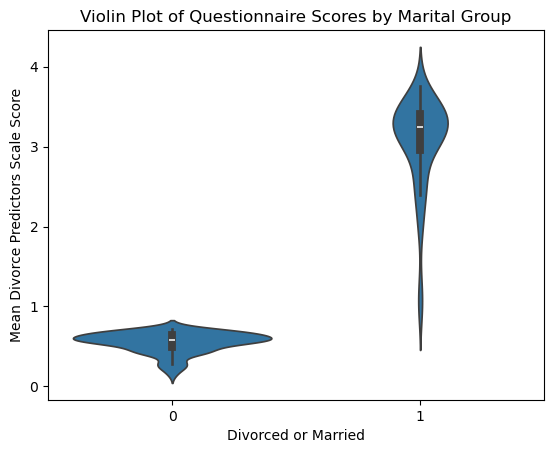

In [6]:
# To see the differences in scores between the married and divorced group, I wanted
# to make side-by-side violin plots to see if there were any major differences.
sns.violinplot(x='Class', y='mean_Atr', data=data)
plt.xlabel('Divorced or Married')
plt.ylabel('Mean Divorce Predictors Scale Score')
plt.title('Violin Plot of Questionnaire Scores by Marital Group')
plt.show()
# It appears that couples who got divorced had much lower mean DPS scores compared to
# people who stayed married.

In [7]:
# Assigns the correlations of all variables in the data frame to the variable 'corrs'.
corrs = data.corr()

# Unstacks the correlations into an array.
numb_array = corrs.unstack()

# Assigns all correlations that are greater than 0.90 or less than -0.90 to
# 'redun_array', since those variables may be considered redundant.
redun_array = numb_array[((numb_array > 0.90) | (numb_array < -0.90)) &
                        (numb_array != 1)]
# Prints the array.
print(redun_array)

# To get rid of redundant variables, I will get rid of variables that highly correlate 
# with one another. These include: Atr5, Atr8, Atr9, Atr11, Atr13, Atr14, Atr16, Atr17, 
# Atr18, Atr19, Atr20, Atr21, Atr22, Atr23, Atr26, Atr29, Atr33, Atr34, Atr35, Atr36, 
# Atr40, Atr41, and mean_Atr. 

Atr1      Atr19       0.900446
Atr5      Atr9        0.916327
          Atr11       0.936955
          Atr13       0.915033
          Atr17       0.947429
          Atr19       0.943349
          Atr29       0.925601
          mean_Atr    0.949574
Atr8      Atr9        0.915301
          Atr18       0.941084
          Atr20       0.922465
          Atr30       0.902820
          mean_Atr    0.917132
Atr9      Atr5        0.916327
          Atr8        0.915301
          Atr11       0.911557
          Atr15       0.949041
          Atr17       0.922307
          Atr18       0.925543
          Atr19       0.916472
          Atr20       0.902254
          Atr21       0.909428
          Atr27       0.903959
          Class       0.912368
          mean_Atr    0.942314
Atr10     Atr16       0.922320
Atr11     Atr5        0.936955
          Atr9        0.911557
          Atr13       0.909464
          Atr17       0.944807
          Atr18       0.909451
          Atr19       0.950068
        

In [8]:
# Drops the columns of redundant variables.
data = data.drop(columns=['Atr5', 'Atr8', 'Atr9', 'Atr11', 'Atr13', 'Atr14', 'Atr16', 
                          'Atr17', 'Atr18', 'Atr19', 'Atr20', 'Atr21', 'Atr22', 'Atr23', 
                          'Atr26', 'Atr29', 'Atr33', 'Atr34', 'Atr35', 'Atr36', 'Atr40', 
                          'Atr41', 'mean_Atr'])
print(data.head())

   Atr1  Atr2  Atr3  Atr4  Atr6  Atr7  Atr10  Atr12  Atr15  Atr24  ...  Atr46  \
0     2     2     4     1     0     0      0      0      0      0  ...      2   
1     4     4     4     4     0     0      4      3      4      2  ...      2   
2     2     2     2     2     3     2      2      4      3      2  ...      3   
3     3     2     3     2     3     3      3      3      3      1  ...      2   
4     2     2     1     1     1     0      0      1      1      0  ...      2   

   Atr47  Atr48  Atr49  Atr50  Atr51  Atr52  Atr53  Atr54  Class  
0      1      3      3      3      2      3      2      1      1  
1      2      3      4      4      4      4      2      2      1  
2      2      3      1      1      1      2      2      2      1  
3      2      3      3      3      3      2      2      2      1  
4      1      2      3      2      2      2      1      0      1  

[5 rows x 33 columns]


##### Split the Data

In [9]:
# Splits the data into features and target variables.
X = data.drop(columns='Class')
y = data['Class']

# Splits the data into training and test sets with a random state of 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.25,
                                                   random_state=42)
# Scales the data for some of the models.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

##### Logistic Regression RFECV

Optimal number of features: 7


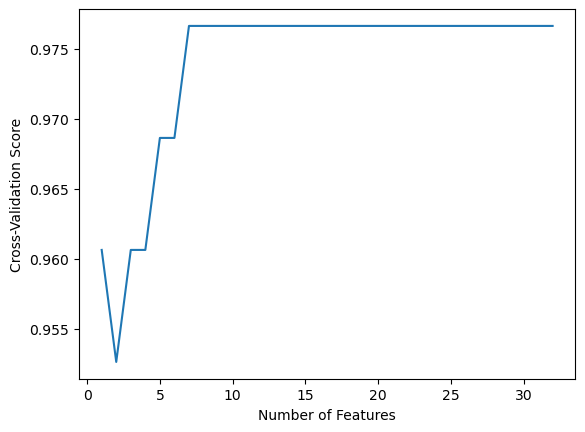

In [10]:
# Initializes the Logistic Regression model.
lr_model = LogisticRegression(max_iter=10000)

# Assigns the necessary parameters for the RFECV for the logistic regression.
lr_rfecv = RFECV(estimator=lr_model, step=1, cv=5, scoring='accuracy')
# Fits the RFECV to the training data.
lr_rfecv.fit(X_train_scaled, y_train)

# Prints and plots the optimal amount of features for the logistic regression
# RFECV.
print("Optimal number of features: %d" % lr_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(lr_rfecv.cv_results_["mean_test_score"]) + 1),
        lr_rfecv.cv_results_["mean_test_score"])
plt.show()

In [11]:
# Initializes the RFE, defining the model (logistic regression) and the
# number of features to choose (found in RFECV).
lr_rfe = RFE(estimator=lr_model, n_features_to_select=7)

# Fits the RFE to the training data.
lr_rfe.fit(X_train_scaled, y_train)

# Finds the best features and prints them out for later use.
lr_features = X.columns[lr_rfe.support_]
print(lr_features)

Index(['Atr3', 'Atr12', 'Atr15', 'Atr28', 'Atr31', 'Atr39', 'Atr44'], dtype='object')


##### Decision Tree Classifier RFECV

Optimal number of features: 1


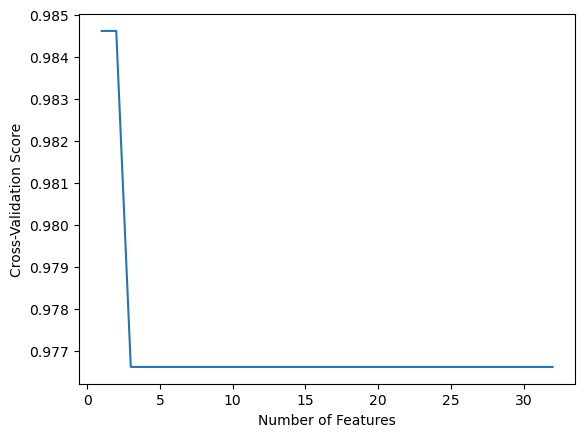

In [12]:
# Initializes the Decision Tree Classifier model.
dtc_model = DecisionTreeClassifier(random_state=42)

# Assigns the necessary parameters for the RFECV for the decision tree classifier.
dtc_rfecv = RFECV(estimator=dtc_model, step=1, cv=5, scoring="accuracy")

# Fits the RFECV to the training data.
dtc_rfecv.fit(X_train, y_train)

# Prints and plots the optimal amount of features for the decision tree classifier
# RFECV.
print("Optimal number of features: %d" % dtc_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(dtc_rfecv.cv_results_["mean_test_score"]) + 1),
        dtc_rfecv.cv_results_["mean_test_score"])
plt.show()

In [13]:
# Initializes the RFE, defining the model (decision tree classifier) and the 
# number of features to choose (found in RFECV).
dtc_rfe = RFE(estimator=dtc_model, n_features_to_select=1)

# Fits the RFE to the training data.
dtc_rfe.fit(X_train, y_train)

# Finds the best features and prints them out for later use.
dtc_features = X_train.columns[dtc_rfe.support_]
print(dtc_features)

Index(['Atr38'], dtype='object')


##### Random Forest Classifier

Optimal number of features: 7


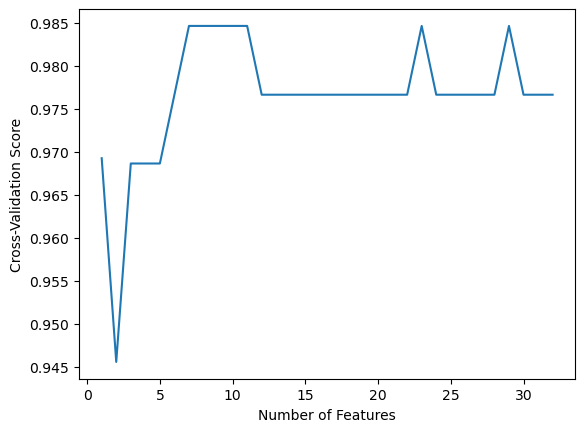

In [14]:
# Initializes the Random Forest Classifier model.
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Assigns the necessary parameters for the RFECV for the random forest classifier.
rfc_rfecv = RFECV(estimator=rfc_model, step=1, cv=5, scoring="accuracy")

# Fits the RFECV to the training data.
rfc_rfecv.fit(X_train, y_train)

# Prints and plots the optimal amount of features for the random forest classifier
# RFECV.
print("Optimal number of features: %d" % rfc_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(rfc_rfecv.cv_results_["mean_test_score"]) + 1),
        rfc_rfecv.cv_results_["mean_test_score"])
plt.show()

In [15]:
# Initializes the RFE, defining the model (random forest classifier) and the 
# number of features to choose (found in RFECV).
rfc_rfe = RFE(estimator=rfc_model, n_features_to_select=7)

# Fits the RFE to the training data.
rfc_rfe.fit(X_train, y_train)

# Finds the best features and prints them out for later use.
rfc_features = X_train.columns[rfc_rfe.support_]
print(rfc_features)

Index(['Atr4', 'Atr12', 'Atr15', 'Atr25', 'Atr28', 'Atr30', 'Atr38'], dtype='object')


##### Support Vector Classifier RFECV

Optimal number of features: 5


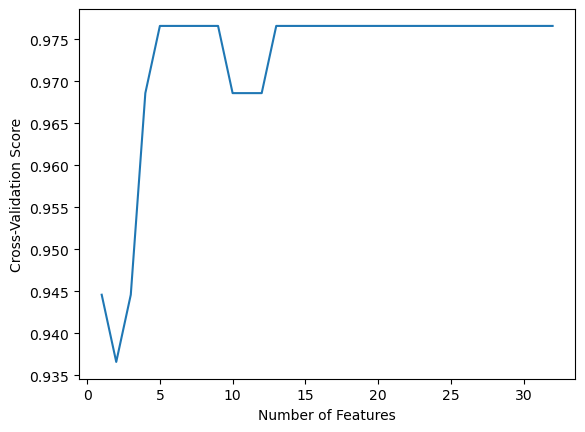

In [16]:
# Initializes the Support Vector Classifier model. 
svc_model = SVC(kernel='linear')

# Assigns the necessary parameters for the RFECV for the support vector classifier.
svc_rfecv = RFECV(estimator=svc_model, step=1, cv=5, scoring="accuracy")

# Fits the RFECV to the scaled training data.
svc_rfecv.fit(X_train_scaled, y_train)

# Prints and plots the optimal amount of features for the support vector classifier
# RFECV.
print("Optimal number of features: %d" % svc_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(svc_rfecv.cv_results_["mean_test_score"]) + 1),
        svc_rfecv.cv_results_["mean_test_score"])
plt.show()

In [17]:
# Initializes the RFE, defining the model (support vector classifier) and the
# number of features to choose (found in the RFECV).
svc_rfe = RFE(estimator=svc_model, n_features_to_select=5)

# Fits the RFE to the training data.
svc_rfe.fit(X_train, y_train)

# Finds the best features and prints them out for later use.
svc_features = X_train.columns[svc_rfe.support_]
print(svc_features)

Index(['Atr2', 'Atr15', 'Atr28', 'Atr39', 'Atr44'], dtype='object')


##### Organizing Selected Features

In [18]:
# Dumps the selected features for each model into their own variable.
selected_features_lr = ['Atr3', 'Atr12', 'Atr15', 'Atr28', 'Atr31', 'Atr39', 'Atr44']
selected_features_dtc = ['Atr38']
selected_features_rfc = ['Atr4', 'Atr12', 'Atr15', 'Atr25', 'Atr28', 'Atr30', 'Atr38']
selected_features_svc = ['Atr2', 'Atr15', 'Atr28', 'Atr39', 'Atr44']

# Converts the X_train data into a list to enumerate over their indices.
feature_names = X_train.columns.tolist()
feature_indices = {name: idx for idx, name in enumerate(feature_names)}

# Finds the indices for each feature for each model and saves them as a variable.
selected_features_lr_indices = [feature_indices[name] for name in 
                                selected_features_lr]
selected_features_dtc_indices = [feature_indices[name] for name in 
                                 selected_features_dtc]
selected_features_rfc_indices = [feature_indices[name] for name in 
                                 selected_features_rfc]
selected_features_svc_indices = [feature_indices[name] for name in 
                                 selected_features_svc]

# Creates new X training and test variables for each model based on their 
# selected features.
X_train_scaled_lr = X_train_scaled[:, selected_features_lr_indices]
X_test_scaled_lr = X_test_scaled[:, selected_features_lr_indices]
X_train_dtc = X_train.iloc[:, selected_features_dtc_indices].values
X_test_dtc = X_test.iloc[:, selected_features_dtc_indices].values
X_train_scaled_rfc = X_train_scaled[:, selected_features_rfc_indices]
X_test_scaled_rfc = X_test_scaled[:, selected_features_rfc_indices]
X_train_scaled_svc = X_train_scaled[:, selected_features_svc_indices]
X_test_scaled_svc = X_test_scaled[:, selected_features_svc_indices]

##### Grid Searches

Logistic Regression

In [19]:
# Defines the parameters to search through for the LR GridSearchCV.
lr_param_grid = {'C': [0.1, 1, 10, 100],
                  'solver': ['liblinear', 'lbfgs']}

# Initializes the LR GridSearchCV.
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=lr_param_grid,
                              cv=5, scoring='accuracy', n_jobs=-1)

# Performs the grid search on the selected training data.
grid_search_lr.fit(X_train_scaled, y_train)

# Gets the best parameters for the LR model.
best_params_lr = grid_search_lr.best_params_

# Finds the best LR model and stores it into a variable and prints it. 
best_lr_model = grid_search_lr.best_estimator_
best_lr_model

LogisticRegression(C=0.1, max_iter=10000, solver='liblinear')

Decision Tree Classifier

In [20]:
# Defines the parameters to search through for the DTC GridSearchCV.
dtc_param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [None, 10, 20, 30],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4],
                  'max_features': ['sqrt', 'log2', None,
                                  0.5, 1, 2, 3],
                  'class_weight': [None, 'balanced']}

# Initializes the DTC GridSearchCV.
grid_search_dtc = GridSearchCV(estimator=dtc_model, param_grid=dtc_param_grid,
                              cv=5, scoring='accuracy', n_jobs=-1)

# Performs the grid search on the selected training data.
grid_search_dtc.fit(X_train, y_train)

# Gets the best parameters for the DTC model.
best_params_dtc = grid_search_dtc.best_params_

# Finds the best DTC model and stores it into a variable and prints it. 
best_dtc_model = grid_search_dtc.best_estimator_
best_dtc_model

DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

Random Forest Classifier

In [21]:
# Defines the parameters to search through for the RFC GridSearchCV.
rfc_param_grid = {'n_estimators': [50, 100, 200],
                  'max_depth': [None, 10, 20, 30],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4]}

# Initializes the RFC GridSearchCV.
grid_search_rfc = GridSearchCV(estimator=rfc_model, param_grid=rfc_param_grid,
                              cv=5, scoring='accuracy', n_jobs=-1)

# Performs the grid search on the selected training data.
grid_search_rfc.fit(X_train_scaled, y_train)

# Gets the best parameters for the RFC model.
best_params_rfc = grid_search_rfc.best_params_

# Finds the best RFC model and stores it into a variable and prints it. 
best_rfc_model = grid_search_rfc.best_estimator_
best_rfc_model

RandomForestClassifier(n_estimators=50, random_state=42)

Support Vector Classifier

In [22]:
# Defines the parameters to search through for the SVC GridSearchCV.
svc_param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'C': [0.1, 1, 10, 100, 1000]}

# Initializes the SVC GridSearchCV. I also re-initialized the model estimator due 
# to the fact that I had to specify a kernel when finding the best features.
grid_search_svc = GridSearchCV(estimator=SVC(), param_grid=svc_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)

# Performs the grid search on the selected training data.
grid_search_svc.fit(X_train_scaled, y_train)

# Gets the best parameters for the SVC model.
best_params_svc = grid_search_svc.best_params_

# Finds the best SVC model and stores it into a variable and prints it.
best_svc_model = grid_search_svc.best_estimator_
best_svc_model

SVC(C=0.1, gamma=1, kernel='poly')

##### Models

Logistic Regression

In [23]:
# Fits the logistic regression model to all training features.
best_lr_model.fit(X_train_scaled, y_train)

# Makes predictions on the testing data set.
lr_preds = best_lr_model.predict(X_test_scaled)

In [24]:
# Evaluates the LR model via an accuracy score and a classification report.
lr_accuracy = accuracy_score(y_test, lr_preds)
lr_classification = classification_report(y_test, lr_preds)

# Prints the results.
print("Logistic Regression Accuracy: {}".format(lr_accuracy))
print("Logistic Regression Classification Report:\n {}".format(lr_classification))

Logistic Regression Accuracy: 0.9767441860465116
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.96      0.98        23

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



In [25]:
# Fits the logistic regression model to the selected training features.
best_lr_model.fit(X_train_scaled_lr, y_train)

# Makes predictions on the testing data set.
lr_preds2 = best_lr_model.predict(X_test_scaled_lr)

In [26]:
# Evaluates the LR model via an accuracy score and a classification report.
lr_accuracy2 = accuracy_score(y_test, lr_preds2)
lr_classification2 = classification_report(y_test, lr_preds2)

# Prints the results.
print("Logistic Regression Accuracy: {}".format(lr_accuracy2))
print("Logistic Regression Classification Report:\n {}".format(lr_classification2))

Logistic Regression Accuracy: 0.9767441860465116
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.96      0.98        23

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



Decision Tree Classifier 

In [27]:
# Fits the DTC model using the best parameters and all features.
best_dtc_model.fit(X_train, y_train)

# Calculates the predictions on the test data.
dtc_preds = best_dtc_model.predict(X_test)

In [28]:
# Evaluates the DTC model via an accuracy score and a classification report.
dtc_accuracy = accuracy_score(y_test, dtc_preds)
dtc_classification = classification_report(y_test, dtc_preds)

# Prints the results.
print("Decision Tree Classifier Accuracy: {}".format(dtc_accuracy))
print("Decision Tree Classifier Classification Report:\n {}".format(dtc_classification))

Decision Tree Classifier Accuracy: 0.813953488372093
Decision Tree Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.83      0.83      0.83        23

    accuracy                           0.81        43
   macro avg       0.81      0.81      0.81        43
weighted avg       0.81      0.81      0.81        43



In [29]:
# Fits the DTC model using the best parameters and selected features.
best_dtc_model.fit(X_train_dtc, y_train)

# Calculates the predictions on the test data.
dtc_preds2 = best_dtc_model.predict(X_test_dtc)

In [30]:
# Evaluates the DTC model via an accuracy score and a classification report.
dtc_accuracy2 = accuracy_score(y_test, dtc_preds2)
dtc_classification2 = classification_report(y_test, dtc_preds2)

# Prints the results.
print("Decision Tree Classifier Accuracy: {}".format(dtc_accuracy2))
print("Decision Tree Classifier Classification Report:\n {}".format(dtc_classification2)
     )

Decision Tree Classifier Accuracy: 0.813953488372093
Decision Tree Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.83      0.83      0.83        23

    accuracy                           0.81        43
   macro avg       0.81      0.81      0.81        43
weighted avg       0.81      0.81      0.81        43



Random Forest Classifier

In [31]:
# Fits the RFC model using the best parameters and all features.
best_rfc_model.fit(X_train_scaled, y_train)

# Calculates the predictions on the test data.
rfc_preds = best_rfc_model.predict(X_test_scaled)

In [32]:
# Evaluates the RFC model via an accuracy score and a classification report.
rfc_accuracy = accuracy_score(y_test, rfc_preds)
rfc_classification = classification_report(y_test, rfc_preds)

# Prints the results.
print("Random Forest Classifier Accuracy: {}".format(rfc_accuracy))
print("Random Forest Classifier Classification Report:\n {}".format(rfc_classification))

Random Forest Classifier Accuracy: 0.9767441860465116
Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.96      0.98        23

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



In [33]:
# Fits the RFC model using the best parameters and the selected features.
best_rfc_model.fit(X_train_scaled_rfc, y_train)

# Calculates the predictions on the test data.
rfc_preds2 = best_rfc_model.predict(X_test_scaled_rfc)

In [34]:
# Evaluates the RFC model via an accuracy score and a classification report.
rfc_accuracy2 = accuracy_score(y_test, rfc_preds2)
rfc_classification2 = classification_report(y_test, rfc_preds2)

# Prints the results.
print("Random Forest Classifier Accuracy: {}".format(rfc_accuracy2))
print("Random Forest Classifier Classification Report:\n {}".format(rfc_classification2)
     )

Random Forest Classifier Accuracy: 0.9534883720930233
Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.96      0.96      0.96        23

    accuracy                           0.95        43
   macro avg       0.95      0.95      0.95        43
weighted avg       0.95      0.95      0.95        43



Support Vector Classifier

In [35]:
# Fits the SVC model using the best parameters and all features.
best_svc_model.fit(X_train_scaled, y_train)

# Calculates the predictions on the test data.
svc_preds = best_svc_model.predict(X_test_scaled)

In [36]:
# Evaluates the SVC model via an accuracy score and a classification report.
svc_accuracy = accuracy_score(y_test, svc_preds)
svc_classification = classification_report(y_test, svc_preds)

# Prints the results.
print("Support Vector Classifier Accuracy: {}".format(svc_accuracy))
print("Support Vector Classifier Classification Report:\n {}".format(svc_classification)
     )

Support Vector Classifier Accuracy: 1.0
Support Vector Classifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        23

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



In [37]:
# Fits the SVC model using the best parameters and selected features.
best_svc_model.fit(X_train_scaled_svc, y_train)

# Calculates the predictions on the test data.
svc_preds2 = best_svc_model.predict(X_test_scaled_svc)

In [38]:
# Evaluates the SVC model via an accuracy score and a classification report.
svc_accuracy2 = accuracy_score(y_test, svc_preds2)
svc_classification2 = classification_report(y_test, svc_preds2)

# Prints the results.
print("Support Vector Classifier Accuracy: {}".format(svc_accuracy2))
print("Support Vector Classifier Classification Report:\n {}".format(svc_classification2
                                                                    ))

Support Vector Classifier Accuracy: 0.9767441860465116
Support Vector Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.96      0.98        23

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43

